[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/barini-onkundi/malaria-spatial-modelling-pymc/blob/main/malaria_prevalence.ipynb)

In [ ]:
!pip install nbstripout
!nbstripout malaria_prevalence.ipynb

# Malaria Prevalence Modeling in Western Kenya

**Author**: DR. Geoffrey Barini  
**Affiliation:** Department of Pure and Applied Mathematics, Jomo Kenyatta University of Agriculture and Technology  
**Email:** barini@jkuat.ac.ke  
**Date:** March 2025


In [1]:
#---connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#---set working directory
import os
os.chdir('/content/drive/My Drive/KENYA') #--change directory
os.getcwd() #--check whether has been set correctly

'/content/drive/My Drive/KENYA'

In [ ]:
#---install pym depencies
!pip install mapclassify
!pip install rasterio
!pip install contextily
!pip install numpyro
!pip install arviz
!pip install fiona
!pip install rioxarray

In [26]:
#---imports
from PIL import Image
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
import folium
import contextily as ctx
import geopandas as gpd
import mapclassify
import rasterio as rio
from pyproj import Transformer
from rasterio.transform import xy
from rasterio.mask import mask
import fiona
import matplotlib.pyplot as plt
from rasterio.warp import calculate_default_transform, reproject, Resampling
from shapely.geometry import Point
from rasterio import Affine
from shapely.ops import unary_union
from scipy.spatial import cKDTree
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from pathlib import Path
from shapely.geometry import mapping

# Data Processing and EDA

In [5]:
#--load malaria prevalence file
try:
    kenya = pd.read_csv("pr_data.csv")
except FileNotFoundError:
    kenya = pd.read_csv(pm.get_data("pr_data.csv"))
kenya.head()

,longitude,latitude,total_tested,total_positive,prevalence
0,33.97000,0.10000,593,163.0,0.274874
1,33.99400,0.15800,171,117.0,0.684211
2,34.02000,-0.03000,237,51.0,0.215190
3,34.02000,0.22000,210,66.0,0.314286
4,34.05003,0.22096,110,56.0,0.509091


In [7]:
#---convert total tested and positive to integer
kenya[["total_positive", "total_tested"]] = kenya[["total_positive", "total_tested"]].astype(int)
kenya.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1230 entries, 0 to 1229
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   longitude       1230 non-null   float64
 1   latitude        1230 non-null   float64
 2   total_tested    1230 non-null   int64  
 3   total_positive  1230 non-null   int64  
 4   prevalence      1230 non-null   float64
dtypes: float64(3), int64(2)
memory usage: 48.2 KB


### shape files

In [6]:
#----countries level 1 admin  shapefile
admin1_gdf = gpd.read_file("/content/drive/My Drive/KENYA/ADM_KE/ken_admbnda_adm1_iebc_20191031.shp")

#---list of lake region malaria endemic counties
target_counties = ["Kisumu", "Siaya", "Homa Bay", "Migori", "Busia", "Vihiga", "Bungoma", "Kakamega"]

#---filter the selected counties
filtered_counties= admin1_gdf[admin1_gdf["ADM1_EN"].isin(target_counties)]

#---ensure CRS is in WGS84 (EPSG:4326) for compatibility
filtered_counties = filtered_counties.to_crs("EPSG:4326")

### Common area between the counties and lake victoria

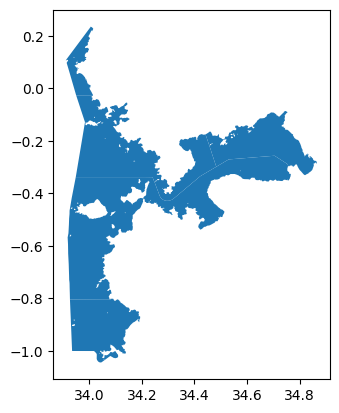

In [12]:
#---load lake victoria shape file
lake = gpd.read_file("/content/drive/My Drive/KENYA/LAKE/Lake_Victoria_Shapefile.shp")
lake =lake.to_crs(filtered_counties.crs)
common_region = gpd.overlay(lake, filtered_counties, how='intersection')

#----plot
common_region.plot();

### Removing water bodies (to avoid model bias)

* Malaria is a human health condition, and its risk factors or prevalence are only meaningful in areas where people live.

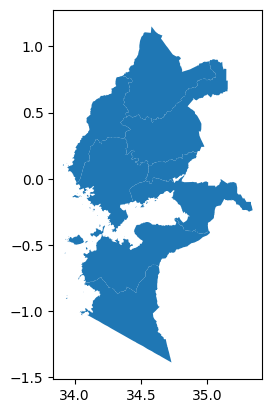

In [14]:
#---land (possibly inhabited area)
counties_inhabited = filtered_counties.copy()
common_region_poly=common_region.union_all()
counties_inhabited["geometry"] = counties_inhabited.geometry.difference(common_region_poly)
counties_inhabited.plot();

### Scatter plot of malaria prevalence

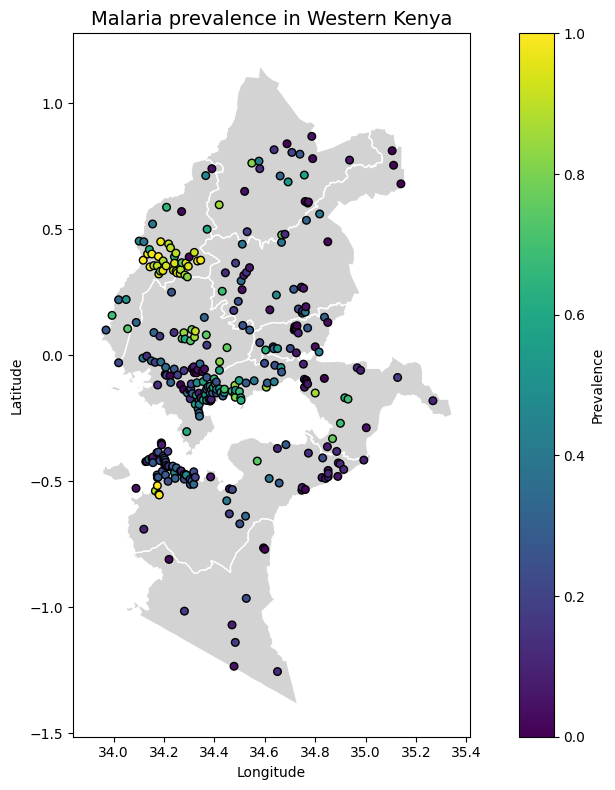

In [16]:
#---create geodataframe from malaria prevalence data
prevalence_gdf = gpd.GeoDataFrame(
    kenya, geometry=gpd.points_from_xy(kenya["longitude"], kenya["latitude"]), crs="EPSG:4326"
)

#---assign each survey point to a county using spatial join
pr_gdf = prevalence_gdf.sjoin(counties_inhabited, how="left", predicate="within")
counties_prev= pr_gdf[pr_gdf["ADM1_EN"].isin(target_counties)]
counties_prev=counties_prev[['longitude','latitude','ADM1_EN','total_tested',	'total_positive',	'prevalence',	'geometry']]

#--ensure CRS match
counties_prev = counties_prev.to_crs(counties_inhabited.crs)

#--extract coordinates for scatter plot
counties_prev["x"] = counties_prev.geometry.x
counties_prev["y"] = counties_prev.geometry.y

#---plot configuration
fig, ax = plt.subplots(figsize=(10, 8))

#---plot counties' area (grey background)
counties_inhabited.plot(ax=ax, color="lightgray", edgecolor="white")

#---scatter points based on prevalence
sc = ax.scatter(counties_prev["x"], counties_prev["y"], c=counties_prev["prevalence"], cmap="viridis", s=30, edgecolor='k')

#---add colorbar
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label("Prevalence")

#---labels and title
ax.set_title("Malaria prevalence in Western Kenya", fontsize=14)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.tight_layout()
plt.show();

### create a polygony for masking environmental raster files

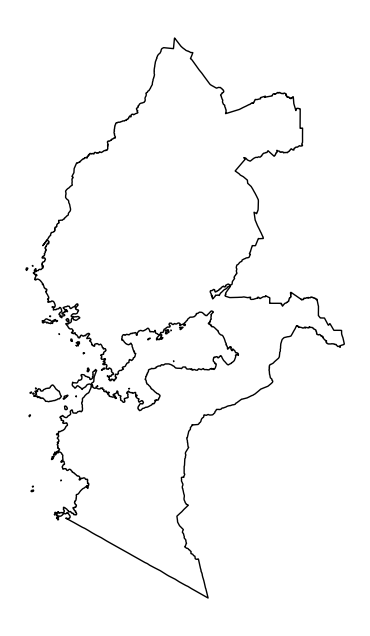

In [21]:
#---merge into a single boundary
merged_boundary = unary_union(counties_inhabited.geometry)

#---convert to geopandas dataframe
merged_gdf = gpd.GeoDataFrame(geometry=[merged_boundary], crs=counties_inhabited.crs)
merged_gdf=merged_gdf.to_crs('EPSG:32736')

#---save to new shapefile
merged_gdf.to_file("merged_boundary.shp")

#---plot
fig, ax = plt.subplots(figsize=(8, 8))
merged_gdf.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=1)
ax.axis('off')
plt.show()

### Load and inspect environmental covariates raster files

In [17]:
#---raster path
raster_dir = Path("/content/drive/My Drive/KENYA/covariates")

#---read the files
raster_files = list(raster_dir.glob("*.tif"))

#---print the file names
for raster in raster_files:
    print(raster)

#---loop over the files
for raster_path in raster_files:
    print(f"=== Raster File: {raster_path} ===")
    with rio.open(raster_path) as src:
        crs = src.crs
        resolution = src.res
        bounds = src.bounds
        nodata = src.nodata
        num_bands = src.count
        dtype = src.dtypes[0]

        #--- print meta data
        print(f"CRS: {crs}")
        print(f"Resolution: {resolution}")
        print(f"Extent (Bounds): {bounds}")
        print(f"NoData Value: {nodata}")
        print(f"Number of Bands: {num_bands}")
        print(f"Data Type: {dtype}")

        #--- check for missing raster values
        band1 = src.read(1)
        if nodata is not None:
            nodata_count = np.sum(band1 == nodata)
            print(f"Number of NoData pixels in band 1: {nodata_count}")
        else:
            print("NoData value is not defined.")
    print("\n" + "="*50 + "\n")


/content/drive/My Drive/KENYA/covariates/ke_pop.tif
/content/drive/My Drive/KENYA/covariates/precip.tif
/content/drive/My Drive/KENYA/covariates/distance_to_water.tif
/content/drive/My Drive/KENYA/covariates/elev.tif
/content/drive/My Drive/KENYA/covariates/temp.tif
/content/drive/My Drive/KENYA/covariates/net.tif
/content/drive/My Drive/KENYA/covariates/evi.tif
=== Raster File: /content/drive/My Drive/KENYA/covariates/ke_pop.tif ===
CRS: EPSG:4326
Resolution: (0.0083333333, 0.0083333333)
Extent (Bounds): BoundingBox(left=33.9070832014676, bottom=-4.725416440136145, right=41.8820831695676, top=5.466250185763855)
NoData Value: -99999.0
Number of Bands: 1
Data Type: float32
Number of NoData pixels in band 1: 490149


=== Raster File: /content/drive/My Drive/KENYA/covariates/precip.tif ===
CRS: EPSG:32736
Resolution: (1000.0, 1000.0)
Extent (Bounds): BoundingBox(left=601000.0, bottom=9846000.0, right=761000.0, top=10128000.0)
NoData Value: None
Number of Bands: 1
Data Type: float64
NoData

### Summary statistics of raster data

In [18]:
#---examine raster values
def summarize_raster_values(raster_dir):

    raster_dir = Path(raster_dir)

    print(f"\nSummary of raster values in: {raster_dir.resolve()}\n")
    print(f"{'Filename':40s} {'Min':>10} {'Max':>10} {'Mean':>10} {'Std':>10}")

    for tif_path in raster_dir.glob("*.tif"):
        try:
            with rio.open(tif_path) as src:
                data = src.read(1).astype("float64")
                if src.nodata is not None:
                    data = np.where(data == src.nodata, np.nan, data)

                #---compute summary statistics ignoring NaN
                min_val = np.nanmin(data)
                max_val = np.nanmax(data)
                mean_val = np.nanmean(data)
                std_val = np.nanstd(data)

                print(f"{tif_path.name:40s} {min_val:10.2f} {max_val:10.2f} {mean_val:10.2f} {std_val:10.2f}")
        except Exception as e:
            print(f"[ERROR] {tif_path.name}: {e}")


#----
summarize_raster_values(raster_dir )


Summary of raster values in: /content/drive/My Drive/KENYA/covariates

Filename                                        Min        Max       Mean        Std
ke_pop.tif                                     0.00  163047.88      92.71     644.41
precip.tif                                   913.97    2818.65    1903.12     281.09
distance_to_water.tif                          0.00     978.74     168.63     125.27
elev.tif                                       0.00    4191.00     618.28     744.51
temp.tif                                       9.63      23.61      20.76       2.00
net.tif                                        0.00       0.99       0.83       0.25
evi.tif                                       -0.02       0.61       0.38       0.07


### Handling missing raster values

In [19]:
#---function for preprocessing
def process_rasters(input_dir, output_dir, valid_ranges):
    input_dir = Path(input_dir)
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    for tif_path in input_dir.glob("*.tif"):
        print(f"\nProcessing file: {tif_path.name}")

        with rio.open(tif_path) as src:
            data = src.read(1).astype('float64')
            profile = src.profile

            #----for defininng valid_ranges (handle missing data)
            file_key = next((k for k in valid_ranges if k.lower() in tif_path.name.lower()), None)

            if file_key:
                vmin, vmax = valid_ranges[file_key]
                nodata_value = -9999.0

                #---apply range-based mask (to mask missing data)
                mask = (data < vmin) | (data > vmax) | np.isnan(data)
                num_masked = np.sum(mask)
                data[mask] = nodata_value

                #---update profile
                profile.update(dtype='float64', nodata=nodata_value)

                #---processed filename
                processed_name = f"processed_{tif_path.name}"
                out_path = output_dir / processed_name

                with rio.open(out_path, 'w', **profile) as dst:
                    dst.write(data, 1)

                print(f"Processed → {processed_name} | Masked {num_masked} pixels")
            else:
                print(f"Skipped → No valid range defined for '{tif_path.name}'")

#---process the files
valid_ranges = {
    'net': (0.0, 1.0),
    'elev': (0, 6000),
    'ke_pop': (0, 200000),
    'precip': (0, 3000),
    'temp': (5, 40),
    'distance_to_water': (0, 2000),
    'evi': (-1, 1)
}

process_rasters(
    input_dir="/content/drive/My Drive/KENYA/covariates",
    output_dir="/content/drive/My Drive/KENYA/processed_covariates",
    valid_ranges=valid_ranges
)



Processing file: ke_pop.tif
Processed → processed_ke_pop.tif | Masked 490149 pixels

Processing file: precip.tif
Processed → processed_precip.tif | Masked 25590 pixels

Processing file: distance_to_water.tif
Processed → processed_distance_to_water.tif | Masked 25590 pixels

Processing file: elev.tif
Processed → processed_elev.tif | Masked 0 pixels

Processing file: temp.tif
Processed → processed_temp.tif | Masked 25590 pixels

Processing file: net.tif
Processed → processed_net.tif | Masked 59297 pixels

Processing file: evi.tif
Processed → processed_evi.tif | Masked 25590 pixels


### Resample mosquito net use and population rasters to 1km resolution and align them

In [22]:
#---paths
data_dir = Path("/content/drive/My Drive/KENYA/processed_covariates")
data_dir.mkdir(parents=True, exist_ok=True)

#---set CRS and resolution
target_crs = 'EPSG:32736'
target_resolution = 1000

#---raster file to process
raster_files = ['processed_net.tif', 'processed_ke_pop.tif']
reference_raster = data_dir / 'processed_elev.tif'

#---boundary
boundary_gdf = merged_gdf.to_crs(target_crs)
boundary_geom = [mapping(geom) for geom in boundary_gdf.geometry]

#---use reference raster to define target grid
with rio.open(reference_raster) as ref:
    transform, width, height = calculate_default_transform(
        ref.crs, target_crs, ref.width, ref.height, *ref.bounds, resolution=target_resolution
    )
    ref_profile = ref.profile.copy()
    ref_profile.update({
        'crs': target_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

#---process each raster
for fname in raster_files:
    in_path = data_dir / fname
    print(f"Processing {in_path.name}...")

    with rio.open(in_path) as src:
        dst_data = np.empty((ref_profile['height'], ref_profile['width']), dtype='float64')

        #---reproject to target grid
        reproject(
            source=src.read(1),
            destination=dst_data,
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=ref_profile['transform'],
            dst_crs=target_crs,
            resampling=Resampling.bilinear
        )

        #---save reprojected raster temporarily
        temp_path = data_dir / f"temp_{fname}"
        temp_profile = ref_profile.copy()
        temp_profile.update(dtype='float64', count=1)

        with rio.open(temp_path, 'w', **temp_profile) as temp_dst:
            temp_dst.write(dst_data, 1)

    #---mask
    with rio.open(temp_path) as temp_src:
        masked, _ = mask(temp_src, boundary_geom, crop=False, filled=True, nodata=0)
        out_meta = temp_src.meta.copy()

        out_path = data_dir / f"clipped_{fname}"
        with rio.open(out_path, 'w', **out_meta) as dest:
            dest.write(masked)

    os.remove(temp_path)
    print(f"Clipped file saved: {out_path.name}")


Processing processed_net.tif...
Clipped file saved: clipped_processed_net.tif
Processing processed_ke_pop.tif...
Clipped file saved: clipped_processed_ke_pop.tif


### Extract covariate values and corresponding geocoordinates

In [23]:
#---target CRS
target_crs = 'EPSG:4326'

#---processed rasters dir
raster_dir = Path("/content/drive/My Drive/KENYA/processed_covariates")

#---list of raster files
raster_files = sorted([
    raster_dir / f for f in [
        'clipped_processed_net.tif',
        'clipped_processed_ke_pop.tif',
        'processed_precip.tif',
        'processed_temp.tif',
        'processed_evi.tif',
        'processed_elev.tif',
        'processed_distance_to_water.tif'
    ]
])

#----dictionary to store raster data
data = {}
coords = None
valid_indices = None

#---loop through rasters
for i, path in enumerate(raster_files):
    with rio.open(path) as src:
        transform, width, height = calculate_default_transform(
            src.crs, target_crs, src.width, src.height, *src.bounds
        )

        kwargs = src.meta.copy()
        kwargs.update({
            'crs': target_crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        dest = np.empty((height, width), dtype=src.meta['dtype'])

        reproject(
            source=src.read(1),
            destination=dest,
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=transform,
            dst_crs=target_crs,
            resampling=Resampling.nearest
        )

        nodata = src.nodata
        mask = dest != nodata if nodata is not None else ~np.isnan(dest)

        #---get coordinates and valid indices
        if coords is None:
            rows, cols = np.where(mask)
            xs, ys = rio.transform.xy(transform, rows, cols)
            coords = list(zip(xs, ys))
            valid_indices = (rows, cols)

        values = dest[valid_indices]
        name = path.stem.lower()
        data[name] = values

#---combine into dataframe
df = pd.DataFrame(data)
df['longitude'] = [x for x, y in coords]
df['latitude'] = [y for x, y in coords]

#---reorder columns
df = df[['longitude', 'latitude'] + list(data.keys())]

#---print 5 rows of df
#print(df.head())


In [24]:
#---drop missing values
df_clean = df.replace(-9999.0, np.nan).dropna()
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19473 entries, 74 to 44996
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   longitude                    19473 non-null  float64
 1   latitude                     19473 non-null  float64
 2   clipped_processed_ke_pop     19473 non-null  float64
 3   clipped_processed_net        19473 non-null  float64
 4   processed_distance_to_water  19473 non-null  float64
 5   processed_elev               19473 non-null  float64
 6   processed_evi                19473 non-null  float64
 7   processed_precip             19473 non-null  float64
 8   processed_temp               19473 non-null  float64
dtypes: float64(9)
memory usage: 1.5 MB


In [25]:
#--rename the columns
column_list = {
    'processed_evi': 'EVI',
    'processed_temp': 'Temp',
    'processed_distance_to_water': 'DistToWater',
    'processed_precip': 'Precip',
    'processed_elev':'elev',
    'clipped_processed_net':'net',
    'clipped_processed_ke_pop':'pop'
}

df_clean.rename(columns=column_list, inplace=True)

### Standadize covariate values for improved numeical stability and prior consistency

In [27]:
#---covariate columns (excluding 'longitude' and 'latitude')
df_cols = [col for col in df_clean.columns if col in ['EVI','Temp','DistToWater','Precip','elev','net','pop']]

#---initialize the scaler
scaler = StandardScaler()

#----fit and transform the covariates
df_clean[df_cols] = scaler.fit_transform(df_clean[df_cols])

In [28]:
#---save as csv file
output_path = "/content/drive/My Drive/KENYA/processed_covariates/cleaned_covariates.csv"
df_clean.to_csv(output_path, index=False)

### Perform nearest neighbor matching
* Next we extract data for environmental predictors of locations for which we have prevalences.

In [ ]:
df_cov =pd.read_csv("/content/drive/My Drive/KENYA/processed_covariates/cleaned_covariates.csv")

# ---extract raster coords
raster_coords = df_cov[['longitude', 'latitude']].values

#---build KDTree from raster coordinates
tree = cKDTree(raster_coords)

#---query nearest neighbors with counties_prev as target file
distances, indices = tree.query(counties_prev[['longitude', 'latitude']].values, k=1)

#---for each covariate column, match by index
covariate_vars = ['EVI','Temp','DistToWater','Precip','elev','net','pop']

for var in covariate_vars:
    matched_values = df_cov[var].values[indices]
    counties_prev[var] = matched_values
    counties_prev[f"{var}_long"] = raster_coords[indices][:, 0]
    counties_prev[f"{var}_lat"] = raster_coords[indices][:, 1]

#---save the result as csv
counties_prev.to_csv("counties_with_covariates.csv", index=False)
counties_with_covariates=pd.read_csv("counties_with_covariates.csv")
counties_with_covariates.head()

### HSGP model variables and parameters

In [31]:
evi=counties_with_covariates["EVI"].values
temp = counties_with_covariates["Temp"].values
precip = counties_with_covariates["Precip"].values
dist = counties_with_covariates["DistToWater"].values
elev = counties_with_covariates["elev"].values
net = counties_with_covariates["net"].values
pop = counties_with_covariates["pop"].values
pos = counties_with_covariates["total_positive"].values
n = counties_with_covariates["total_tested"].values
lonlat =counties_with_covariates[["longitude", "latitude"]].values

In [32]:
#---set seed
seed: int = sum(map(ord, "spatialmalaria"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

## Model Specification

* We will use the binomial likelihood model:
$$Y_{i} \sim Binomial(n_{i}, P(x_{i}))$$
$$logit(P(x_{i})) = \beta_{0} + \beta_{1}evi +\beta_{2}temp +\beta_{3}precip +\beta_{4}dist +\beta_{5}elev+\beta_{6}net+\beta_{7}pop + S(x_{i})$$

* Where $n_{i}$ represents an individual tested for malaria, $P(x_{i})$ is the prevalence of malaria at location $x_{i}$, $\beta_{0}$ is the intercept, $\beta_{i}$ are the cofficients for environmental covariates and $S(x_{i})$ is a zero mean field gaussian process with a Matérn covariance function with $\nu=\frac{3}{2}$ that we will approximate using a Hilbert Space Gaussian Process (HSGP)

* Parameters `m` and `c` required in approximation of a Gaussian process using an HSGP.
* To learn more about how to select these parameters please refer to  ([example](../gaussian_processes/HSGP-Basic.myst.md)).

In [33]:
with pm.Model() as hsgp_model:
    #---spatial coordinates
    _X = pm.Data("X", lonlat)

    #---predictors
    _evi = pm.Data("evi", evi)
    _temp = pm.Data("temp", temp)
    _precip = pm.Data("precip", precip)
    _dist = pm.Data("dist", dist)
    _elev = pm.Data("elev", elev)
    _net = pm.Data("net", net)
    _pop = pm.Data("pop", pop)

    #---GP covariance and hyperparameters
    ls = pm.Gamma("ls", mu=20, sigma=5)
    cov_func = pm.gp.cov.Matern32(2, ls=ls)
    m0, m1, c = 60, 60, 2.5
    gp = pm.gp.HSGP(m=[m0, m1], c=c, cov_func=cov_func)
    s = gp.prior("s", X=_X)

    #---regression coefficients (normal priors with mean 0 and std 1 since covariates are standardized)
    beta_0 = pm.Normal("beta_0", 0, 1)
    beta_1 = pm.Normal("beta_1", 0, 1)  #---evi
    beta_2 = pm.Normal("beta_2", 0, 1)  #---temp
    beta_3 = pm.Normal("beta_3", 0, 1)  #---precip
    beta_4 = pm.Normal("beta_4", 0, 1)  #---dist
    beta_5 = pm.Normal("beta_5", 0, 1)  #---elev
    beta_6 = pm.Normal("beta_6", 0, 1)  #---net
    beta_7 = pm.Normal("beta_7", 0, 1)  #--pop

    #---linear predictor incorporating all predictors plus the spatial effect
    p_logit = pm.Deterministic("p_logit",
                              beta_0 + beta_1 * _evi + beta_2 * _temp + beta_3 * _precip + beta_4 * _dist+beta_5 * _elev+beta_6 * _net+beta_7 * _pop+ s)
    p = pm.Deterministic("p", pm.math.invlogit(p_logit))

    #---likelihood: assuming a binomial model (with n trials, observed successes pos)
    pm.Binomial("likelihood", n=n, logit_p=p_logit, observed=pos)


## graphical representation of the model

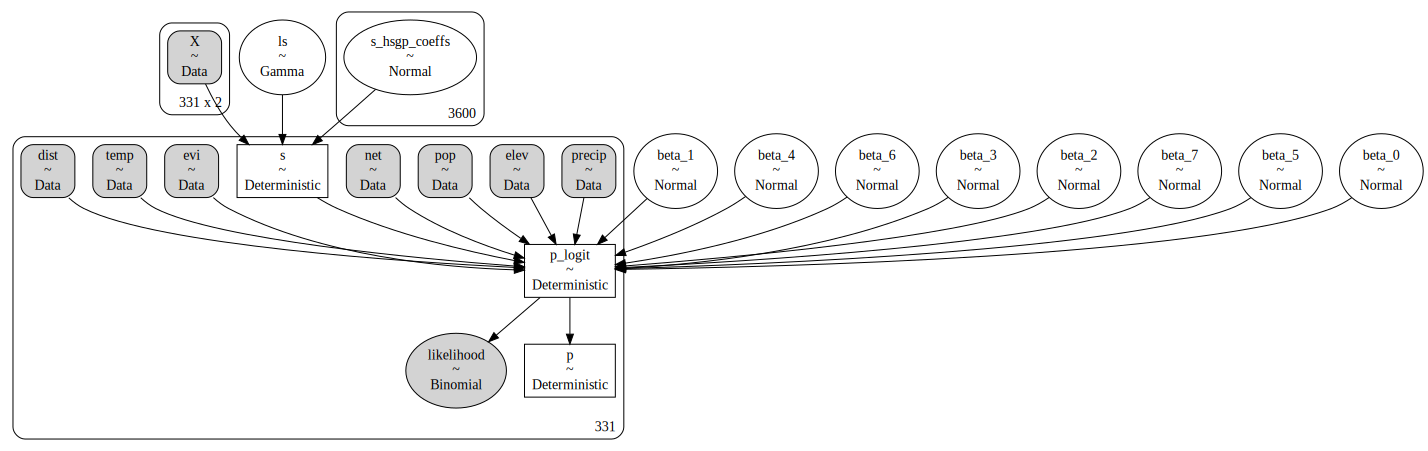

In [34]:
hsgp_model.to_graphviz()

In [35]:
#---run the HSGP model
with hsgp_model:
    hsgp_trace = pm.sample(
        500, tune=500, target_accept=0.95, nuts_sampler="numpyro", random_seed=rng
    )

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [36]:
#---statistical summary of lenght scale
az.summary(hsgp_trace, var_names=["ls"], kind="stats") #default is 94% but can be set to hdi_prob=0.95

,mean,sd,hdi_3%,hdi_97%
ls,0.038,0.001,0.036,0.041


* Here, the length scale (ls) is a key hyperparameter in Gaussian Processes (GPs) and Hilbert Space Gaussian Processes (HSGPs) that controls how quickly spatial correlations decay over distance.
* The small mean value of lenght scale, ls = 0.038 implies that spatial correlation decays very rapidly (over 3.8% of the spatial domain if inputs are scaled to [0, 1]).

* This suggests strong evidence of local spatial heterogeneity, that is, malaria prevalence differs sharply over small distances.
* The narrow 94% credible interval [0.036, 0.041] suggests very high certainty about this pattern.
* *Note:* We can obtain 95% credible interval by setting **hdi_prob=0.95** in az.summary()

### Posterior Predictive Checks

* We need to ensure that our model accurately captures the observed data. To do this, we can generate posterior predictions of the prevalence and plot them against the spatial coordinates to visually compare how well the predicted values match the observed prevalence from our sample

In [41]:
with hsgp_model:
    ppc = pm.sample_posterior_predictive(hsgp_trace, random_seed=rng)

Output()

In [42]:
posterior_prevalence = hsgp_trace["posterior"]["p"]

In [44]:
#---compute MSE & RMSE
y=counties_with_covariates["prevalence"].values
posterior_p = hsgp_trace.posterior["p"]
posterior_mean = posterior_p.mean(dim=["chain", "draw"]).values
predicted_prevalence = posterior_mean /n
mse = mean_squared_error(y, predicted_prevalence)
rmse = np.sqrt(mse)
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")

MSE: 0.2057
RMSE: 0.4535


* The figure below shows that our posterior predictions on the left closely match the observed sample displayed on the right.

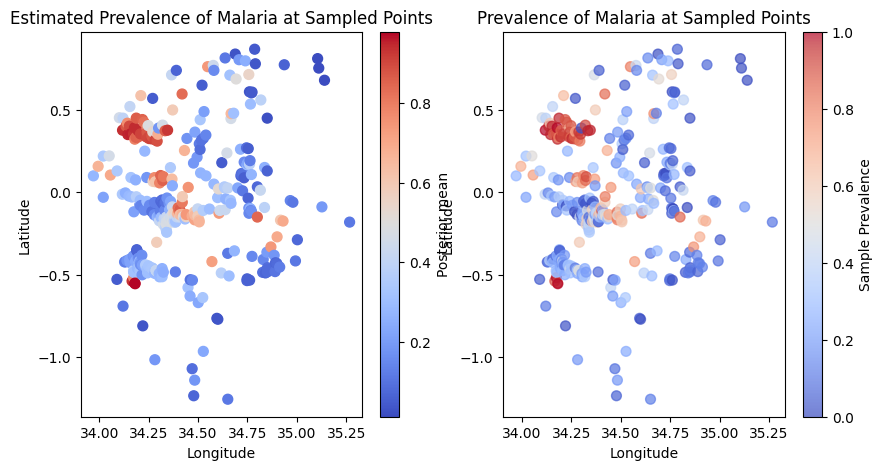

In [48]:
plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
plt.subplot(1, 2, 1)

plt.scatter(
    lonlat[:, 0],
    lonlat[:, 1],
    c=posterior_prevalence.mean(("chain", "draw")),
    marker="o",
    alpha=1,
    s=50,
    cmap="coolwarm",
    edgecolor=None,
)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Estimated Prevalence of Malaria at Sampled Points")
plt.colorbar(label="Posterior mean")

plt.subplot(1, 2, 2)

plt.scatter(
    lonlat[:, 0],
    lonlat[:, 1],
    c=counties_prev["prevalence"],
    marker="o",
    alpha=0.7,
    s=50,
     cmap="coolwarm",
    edgecolor=None,
)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Prevalence of Malaria at Sampled Points")
plt.colorbar(label="Sample Prevalence");

* We can also assess whether the model’s predicted likelihood—specifically, the number of individuals testing positive for malaria—aligns with the observed data. As shown in the figure below, the posterior predictive samples closely reflect the observed outcomes.

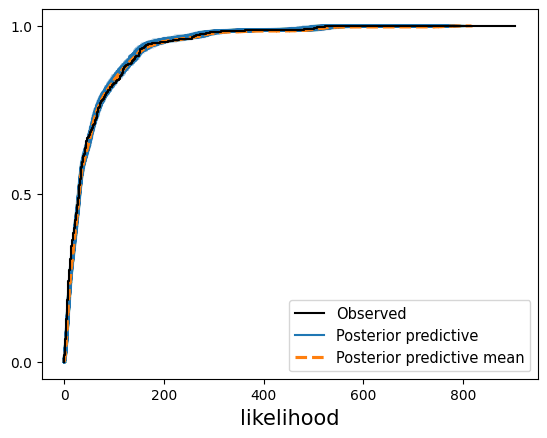

In [49]:
az.plot_ppc(ppc, kind="cumulative");

## Out-of-sample posterior predictions

* Next weestimate the prevalence of diarrhea in areas surrounding our observed data points.
* To do this, we'll use a new dataset that includes every longitude and latitude location within the study area where malaria environmental predictor's data is available.

In [50]:
#---coordinates and covariates
new_lonlat = df_cov [["longitude", "latitude"]].to_numpy()
new_evi = df_cov["EVI"].to_numpy()
new_temp = df_cov["Temp"].to_numpy()
new_precip = df_cov["Precip"].to_numpy()
new_dist = df_cov["DistToWater"].to_numpy()
new_elev = df_cov["elev"].to_numpy()
new_net = df_cov["net"].to_numpy()
new_pop = df_cov["pop"].to_numpy()

#---perform posterior prediction
with hsgp_model:
    pm.set_data(new_data={
        "X": new_lonlat,
        "evi": new_evi,
        "temp": new_temp,
        "precip": new_precip,
        "dist": new_dist,
        "elev": new_elev,
        "net": new_net,
        "pop": new_pop
    })

    pp = pm.sample_posterior_predictive(hsgp_trace, var_names=["p"], random_seed=rng)


Output()

In [51]:
posterior_predictive_prevalence = pp["posterior_predictive"]["p"]

## Mapping predicted malaria prevalence and identifying high-risk areas using exceedance probabilities

* We can visualize our out-of-sample posterior predictions to create a spatial surface map of estimated malaria prevalence across the study area. In the figure below, you’ll notice a smooth gradient of predicted prevalence values radiating from the observed data locations. This reflects the spatial correlation in our model—nearby locations have more similar prevalence estimates, while predictions further from data points tend to shrink toward zero, the mean of the Gaussian Process prior.

* To identify regions where targeted interventions might be most needed, we can examine exceedance probabilities—the probability that the true prevalence exceeds a specified threshold.

* For this analysis, we set a threshold of 30% malaria prevalence. The resulting map highlights areas where we are most confident that prevalence exceeds this critical level, allowing us to prioritize those regions for malaria intervention efforts.

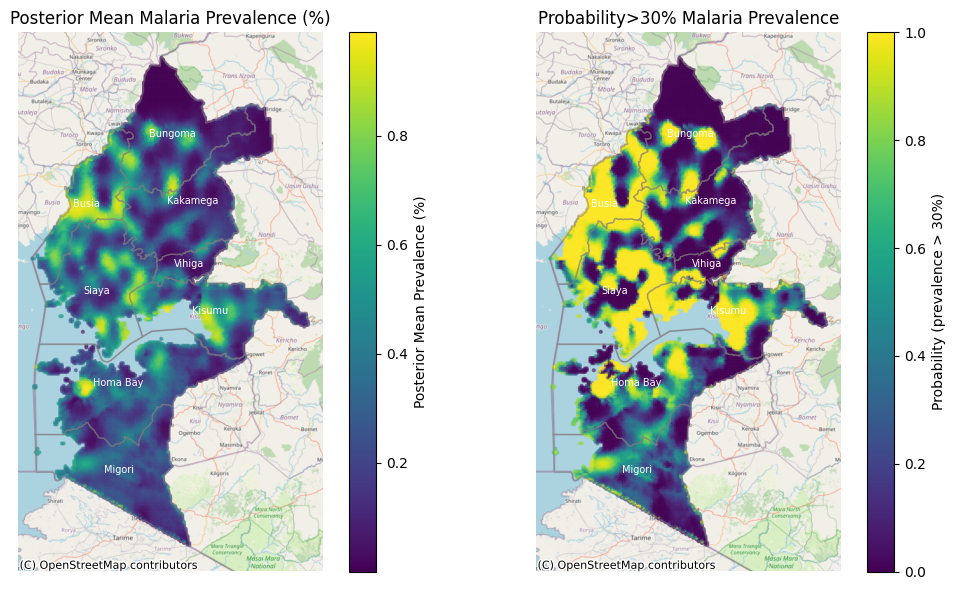

In [52]:
# --- posterior summaries
posterior_mean = posterior_predictive_prevalence.mean(("chain", "draw")).values
prob_prev_exceed_30 = 1 - (posterior_predictive_prevalence <= 0.3).mean(("chain", "draw")).values

# --- geodataframe
points_geom = [Point(xy) for xy in new_lonlat]
gdf_prevalence = gpd.GeoDataFrame({"prevalence": posterior_mean}, geometry=points_geom, crs="EPSG:4326")
gdf_prob_exceed = gpd.GeoDataFrame({"prevalence": prob_prev_exceed_30}, geometry=points_geom, crs="EPSG:4326")

# --- reproject filtered_counties
filtered_counties = filtered_counties.to_crs("EPSG:4326")

# --- merge and clip
merged_boundary = filtered_counties.union_all()
merged_gdf = gpd.GeoDataFrame(geometry=[merged_boundary], crs="EPSG:4326")

clipped_prevalence = gpd.clip(gdf_prevalence, merged_gdf).to_crs(epsg=3857)
clipped_prob_exceed = gpd.clip(gdf_prob_exceed, merged_gdf).to_crs(epsg=3857)
filtered_counties_proj = filtered_counties.to_crs(epsg=3857)

# --- combined plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 6), sharey=True)

# --- plot posterior mean prevalence
sc1 = clipped_prevalence.plot(
    ax=ax1,
    column="prevalence",
    cmap='viridis',
    markersize=4,
    alpha=0.5,
    legend=True,
    legend_kwds={"label": "Posterior Mean Prevalence (%)"}
)
filtered_counties_proj.boundary.plot(ax=ax1, color="grey", linewidth=1, alpha=0.5)
for _, row in filtered_counties_proj.iterrows():
    centroid = row.geometry.centroid
    ax1.text(centroid.x, centroid.y, row["ADM1_EN"], fontsize=7, color="white", ha="center", va="center")
ctx.add_basemap(ax1, source=ctx.providers.OpenStreetMap.Mapnik)
ax1.set_axis_off()
ax1.set_title("Posterior Mean Malaria Prevalence (%)")

# --- plot probability of exceedance
sc2 = clipped_prob_exceed.plot(
    ax=ax2,
    column="prevalence",
    cmap='viridis',
    markersize=4,
    alpha=0.5,
    legend=True,
    legend_kwds={"label": "Probability (prevalence > 30%)"}
)
filtered_counties_proj.boundary.plot(ax=ax2, color="grey", linewidth=1, alpha=0.5)
for _, row in filtered_counties_proj.iterrows():
    centroid = row.geometry.centroid
    ax2.text(centroid.x, centroid.y, row["ADM1_EN"], fontsize=7, color="white", ha="center", va="center")
ctx.add_basemap(ax2, source=ctx.providers.OpenStreetMap.Mapnik)
ax2.set_axis_off()
ax2.set_title("Probability>30% Malaria Prevalence")

# ---
plt.tight_layout()

# ---save the fig
fig.savefig("malaria_prevalence.png", dpi=300, bbox_inches="tight")

# ---
plt.show()


## References

* Adapted from `The prevalence of malaria in the Gambia` by developers of PyMC library ([link](https://www.pymc.io/projects/examples/en/latest/spatial/malaria_prevalence.html)).